## **Predictive Analysis Plan for the Titanic Dataset**  

1. Define the Problem Statement
2. Data Preparation for Modeling
3. Model Selection
4. Model Training & Evaluation
5. Hyperparameter Tuning
6. Model Comparison & Selection
7. Final Model & Predictions
8. Model Interpretation & Explainability
9. Deployment (Optional)


### **1. Define the Problem Statement**  
- Goal: Predict passenger survival (`Survived` column) using available features.  
- Type of problem: Binary Classification (0 = Not Survived, 1 = Survived).  

The goal is to build a machine learning model that predicts whether a passenger survived the Titanic disaster based on various features such as age, sex, passenger class, and fare.

* Objective:

Input: Passenger details (e.g., Age, Sex, Pclass, etc.)
Output: Binary prediction — 0 (Did Not Survive) or 1 (Survived)


* Key Challenges to Address

Imbalanced classes (more non-survivors than survivors).
Presence of missing values (e.g., Cabin, Embarked).
Potentially correlated features (e.g., Pclass and Fare).
Non-linear relationships that might require feature engineering.

* Success Criteria (Metrics)

Primary Metric: F1 Score (balances precision & recall).
Secondary Metrics: Accuracy, ROC-AUC score, and Confusion Matrix for detailed insights.

In [31]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as stats
import time

In [133]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

### **Get Data**

In [33]:
df = pd.read_csv("../data/processed/training_model_ready.csv")
test_df = pd.read_csv("../data/processed/testing_model_ready.csv")
df.head()

,PassengerId,Survived,Pclass,Sex_male,Embarked_Q,Embarked_S,Fare_Bin,Age_Bin,Family_Group
0,1,0,3,True,False,True,0,2,1
1,2,1,1,False,False,False,2,2,1
2,3,1,3,False,False,True,0,2,0
3,4,1,1,False,False,True,2,2,1
4,5,0,3,True,False,True,0,2,0


In [34]:
test_df.head()

,PassengerId,Pclass,Sex_male,Embarked_Q,Embarked_S,Fare_Bin,Age_Bin,Family_Group
0,892,3,True,True,False,0,2,0
1,893,3,False,False,True,0,2,1
2,894,2,True,True,False,0,3,0
3,895,3,True,False,True,0,2,0
4,896,3,False,False,True,1,2,1


In [35]:
# check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   PassengerId   712 non-null    int64
 1   Survived      712 non-null    int64
 2   Pclass        712 non-null    int64
 3   Sex_male      712 non-null    bool 
 4   Embarked_Q    712 non-null    bool 
 5   Embarked_S    712 non-null    bool 
 6   Fare_Bin      712 non-null    int64
 7   Age_Bin       712 non-null    int64
 8   Family_Group  712 non-null    int64
dtypes: bool(3), int64(6)
memory usage: 35.6 KB


In [36]:
test_passenger_id = test_df.PassengerId
test_df.drop(['PassengerId'], axis=1, inplace=True)
train_passenger_id = df.PassengerId
df.drop(['PassengerId'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex_male,Embarked_Q,Embarked_S,Fare_Bin,Age_Bin,Family_Group
0,0,3,True,False,True,0,2,1
1,1,1,False,False,False,2,2,1
2,1,3,False,False,True,0,2,0
3,1,1,False,False,True,2,2,1
4,0,3,True,False,True,0,2,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Survived      712 non-null    int64
 1   Pclass        712 non-null    int64
 2   Sex_male      712 non-null    bool 
 3   Embarked_Q    712 non-null    bool 
 4   Embarked_S    712 non-null    bool 
 5   Fare_Bin      712 non-null    int64
 6   Age_Bin       712 non-null    int64
 7   Family_Group  712 non-null    int64
dtypes: bool(3), int64(5)
memory usage: 30.0 KB


### **Splitting Data**  
  - Use `train_test_split()` to create training (80%) and testing (20%) datasets.  
  - Consider stratified sampling to maintain class distribution balance.  


In [38]:
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split the dataset into training and testing sets, 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# stratify=y : Ensures both train and test sets have similar proportions of survivors and non-survivors. 
# This is crucial since the Titanic dataset has an imbalanced class distribution.

In [39]:
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True))  # Confirm class balance
print(y_test.value_counts(normalize=True))

# we use 'normalize' to get values as ratio(s)

(569, 7) (143, 7)
Survived
0    0.595782
1    0.404218
Name: proportion, dtype: float64
Survived
0    0.594406
1    0.405594
Name: proportion, dtype: float64


### **Feature Scaling**  
  - Standardize numerical features (`Age`, `Fare`) using `StandardScaler()`.  

In [40]:
# scaling is not required. the columns were binned.

### **3. Model Selection**  
- Try multiple algorithms:  
  - **Baseline Model**: Logistic Regression  
  - **Tree-Based Models**: Decision Tree, Random Forest, XGBoost  
  - **Ensemble Methods**: Gradient Boosting, AdaBoost  
  - **Advanced Models**: Support Vector Machine (SVM), Neural Networks (optional)  

We'll start with models that handle categorical data really well. Then, we'll move to linear models.

1. Decision Tree
2. Random Forest
3. CatBoost
4. LightGBM
5. XGBoost (with enable_categorical=True)
5. HistGradientBoostingClassifier (from sklearn with native categorical support)

### **4. Model Training & Evaluation**  
- **Train models** on the training dataset.  
- **Evaluate performance** using:  
  - Accuracy, Precision, Recall, F1-score, ROC-AUC curve  
  - Confusion Matrix for classification errors  
  - Feature Importance (for tree-based models) 

#### Logistic Regression

In [87]:
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7832167832167832
              precision    recall  f1-score   support

           0       0.81      0.82      0.82        85
           1       0.74      0.72      0.73        58

    accuracy                           0.78       143
   macro avg       0.78      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143



#### Decision Trees Classifier

In [120]:
dt_model = DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=12, random_state=42) #, class_weight='balanced')
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

# Performance Metrics

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        85
           1       0.90      0.62      0.73        58

    accuracy                           0.82       143
   macro avg       0.84      0.79      0.80       143
weighted avg       0.83      0.82      0.81       143



#### Random Forest

In [89]:
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_leaf=2,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8041958041958042
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        85
           1       0.79      0.71      0.75        58

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



#### XGB Classifier

In [91]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)\

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8041958041958042
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        85
           1       0.80      0.69      0.74        58

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



#### SVM

In [118]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        85
           1       0.86      0.66      0.75        58

    accuracy                           0.82       143
   macro avg       0.83      0.79      0.80       143
weighted avg       0.82      0.82      0.81       143



#### K-NN

In [96]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7902097902097902
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        85
           1       0.77      0.69      0.73        58

    accuracy                           0.79       143
   macro avg       0.79      0.77      0.78       143
weighted avg       0.79      0.79      0.79       143



#### HistGradient Boost

In [97]:
hgb = HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1, random_state=42)
hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_test)

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8041958041958042
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        85
           1       0.79      0.71      0.75        58

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



#### CatBoost Classifier

In [106]:
cat = CatBoostClassifier(verbose=0, iterations=200, learning_rate=0.01, depth=6, random_seed=42)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7972027972027972
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        85
           1       0.81      0.66      0.72        58

    accuracy                           0.80       143
   macro avg       0.80      0.77      0.78       143
weighted avg       0.80      0.80      0.79       143



#### Extra-Trees Classifier

In [111]:
et = ExtraTreesClassifier(n_estimators=100, max_depth=7, random_state=42)
et.fit(X_train, y_train)
y_pred = et.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7832167832167832
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        85
           1       0.80      0.62      0.70        58

    accuracy                           0.78       143
   macro avg       0.79      0.76      0.76       143
weighted avg       0.79      0.78      0.78       143



#### BaggingClassifier (with DecisionTree base by default)

In [114]:
bag = BaggingClassifier(n_estimators=100, max_samples=0.8, random_state=42)
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7832167832167832
              precision    recall  f1-score   support

           0       0.81      0.82      0.82        85
           1       0.74      0.72      0.73        58

    accuracy                           0.78       143
   macro avg       0.78      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143



#### Ridge Classifier

In [115]:
ridge = RidgeClassifier(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7972027972027972
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        85
           1       0.76      0.72      0.74        58

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



#### Naive Bayes

In [116]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7552447552447552
              precision    recall  f1-score   support

           0       0.82      0.75      0.79        85
           1       0.68      0.76      0.72        58

    accuracy                           0.76       143
   macro avg       0.75      0.76      0.75       143
weighted avg       0.76      0.76      0.76       143



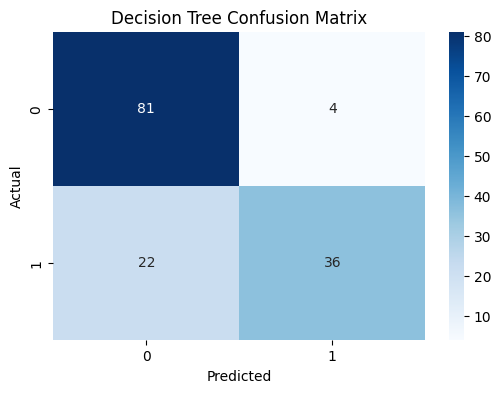

In [121]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

### **5. Hyperparameter Tuning**  
- Use **GridSearchCV** or **RandomizedSearchCV** to optimize models.  

#### Logistic Regression

In [122]:
# Hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

# Evaluate
best_logreg = grid.best_estimator_
y_pred = best_logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.7762237762237763
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        85
           1       0.73      0.71      0.72        58

    accuracy                           0.78       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143



#### KNN

In [126]:
param_grid = {
    'n_neighbors': [3, 5, 7, 8, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy: 0.7552447552447552
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        85
           1       0.74      0.60      0.67        58

    accuracy                           0.76       143
   macro avg       0.75      0.73      0.74       143
weighted avg       0.75      0.76      0.75       143



#### Random Forest

In [129]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 7, 8, 9, 10],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("RF Best Params:", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

RF Best Params: {'bootstrap': False, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.7972027972027972
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        85
           1       0.81      0.66      0.72        58

    accuracy                           0.80       143
   macro avg       0.80      0.77      0.78       143
weighted avg       0.80      0.80      0.79       143



#### Extra Trees

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False]
}
grid = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("ETC Best Params:", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ETC Best Params: {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7762237762237763
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        85
           1       0.75      0.67      0.71        58

    accuracy                           0.78       143
   macro avg       0.77      0.76      0.76       143
weighted avg       0.77      0.78      0.77       143



#### Bagging Classifier

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}
grid = GridSearchCV(BaggingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Bagging Best Params:", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Bagging Best Params: {'bootstrap': True, 'max_samples': 0.7, 'n_estimators': 10}
Accuracy: 0.7622377622377622
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        85
           1       0.71      0.69      0.70        58

    accuracy                           0.76       143
   macro avg       0.75      0.75      0.75       143
weighted avg       0.76      0.76      0.76       143



#### HGB Classifier

In [ ]:
param_dist = {
    'max_iter': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 5, 10]
}
grid = RandomizedSearchCV(HistGradientBoostingClassifier(random_state=42), param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
grid.fit(X_train, y_train)

print("HGB Best Params:", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

HGB Best Params: {'max_iter': 300, 'max_depth': None, 'learning_rate': 0.1}
Accuracy: 0.7972027972027972
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        85
           1       0.77      0.71      0.74        58

    accuracy                           0.80       143
   macro avg       0.79      0.78      0.79       143
weighted avg       0.80      0.80      0.80       143



#### CatBoost

In [135]:
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}
grid = RandomizedSearchCV(CatBoostClassifier(verbose=0, random_state=42), param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
grid.fit(X_train, y_train)

print("CatBoost Best Params:", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

CatBoost Best Params: {'learning_rate': 0.01, 'iterations': 200, 'depth': 8}
Accuracy: 0.7972027972027972
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        85
           1       0.81      0.66      0.72        58

    accuracy                           0.80       143
   macro avg       0.80      0.77      0.78       143
weighted avg       0.80      0.80      0.79       143



#### Decision Trees

In [127]:
param_grid = {
    'max_depth': [None, 5, 7, 8, 9, 10, 15],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("DT Best Params:", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


DT Best Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}
Accuracy: 0.7902097902097902
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        85
           1       0.87      0.57      0.69        58

    accuracy                           0.79       143
   macro avg       0.82      0.76      0.76       143
weighted avg       0.81      0.79      0.78       143



#### Ridge

In [136]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'solver': ['auto', 'saga']
}
grid = GridSearchCV(RidgeClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Ridge Best Params:", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Ridge Best Params: {'alpha': 10.0, 'solver': 'auto'}
Accuracy: 0.8041958041958042
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        85
           1       0.78      0.72      0.75        58

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



#### Gaussian Naive Bayes

In [137]:
param_grid = {
    'var_smoothing': np.logspace(-9, -5, 5)
}
grid = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("GNB Best Params:", grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


GNB Best Params: {'var_smoothing': np.float64(1e-09)}
Accuracy: 0.7552447552447552
              precision    recall  f1-score   support

           0       0.82      0.75      0.79        85
           1       0.68      0.76      0.72        58

    accuracy                           0.76       143
   macro avg       0.75      0.76      0.75       143
weighted avg       0.76      0.76      0.76       143



### **6. Model Comparison & Selection**  
- Compare models and select the best-performing one based on metrics.  

In [15]:
# Sample results DataFrame
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC', 'Training Time', 'Hyperparameters'])

# Example function to log results
def log_results(model, model_name, X_train, X_test, y_train, y_test, params=None):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_time = round(time.time() - start_time, 2)
    results.loc[len(results)] = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred),
        'Training Time': train_time,
        'Hyperparameters': params
    }

In [18]:
# Models with relevant parameters

log_results(DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=10), "Decision Tree", X_train, X_test, y_train, y_test, {'max_depth': 5})

log_results(RandomForestClassifier(n_estimators=200, max_depth=7), "Random Forest", X_train, X_test, y_train, y_test, {'n_estimators': 200, 'max_depth': 7})

log_results(CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, cat_features=['Fare_Bin', 'Age_Bin', 'Family_Group']), "CatBoost", X_train, X_test, y_train, y_test, {'iterations': 200, 'depth': 6, 'learning_rate': 0.1})

log_results(LogisticRegression(solver='lbfgs', max_iter=500), "Logistic Regression", X_train, X_test, y_train, y_test, {'solver': 'lbfgs', 'max_iter': 500})

log_results(GaussianNB(), "Naive Bayes", X_train, X_test, y_train, y_test)

log_results(KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors", X_train, X_test, y_train, y_test, {'n_neighbors': 5})

log_results(SVC(kernel='rbf', C=1.0, probability=True), "Support Vector Machine", X_train, X_test, y_train, y_test, {'kernel': 'rbf', 'C': 1.0})

log_results(HistGradientBoostingClassifier(max_iter=200), "HistGradientBoosting", X_train, X_test, y_train, y_test, {'max_iter': 200})


In [19]:
results

,Model,Accuracy,Precision,Recall,F1,AUC-ROC,Training Time,Hyperparameters
0,Decision Tree,0.790210,0.868421,0.568966,0.687500,0.755071,0.00,{'max_depth': 5}
1,Random Forest,0.783217,0.800000,0.620690,0.699029,0.757404,0.21,"{'n_estimators': 200, 'max_depth': 7}"
2,CatBoost,0.811189,0.781818,0.741379,0.761062,0.800101,6.31,"{'iterations': 200, 'depth': 6, 'learning_rate..."
3,Logistic Regression,0.783217,0.736842,0.724138,0.730435,0.773834,0.01,"{'solver': 'lbfgs', 'max_iter': 500}"
4,Naive Bayes,0.755245,0.676923,0.758621,0.715447,0.755781,0.00,None
5,K-Nearest Neighbors,0.790210,0.769231,0.689655,0.727273,0.774239,0.01,{'n_neighbors': 5}
6,Support Vector Machine,0.818182,0.863636,0.655172,0.745098,0.792292,0.04,"{'kernel': 'rbf', 'C': 1.0}"
7,HistGradientBoosting,0.804196,0.788462,0.706897,0.745455,0.788742,2.21,{'max_iter': 200}
8,Decision Tree,0.790210,0.888889,0.551724,0.680851,0.752333,0.00,{'max_depth': 5}
9,Random Forest,0.783217,0.800000,0.620690,0.699029,0.757404,0.21,"{'n_estimators': 200, 'max_depth': 7}"


### 7. Final Model & Predictions**  
- Train the selected model on the full dataset.  
- Generate predictions on the test dataset. 

In [20]:
train_df = df

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Survived      712 non-null    int64
 1   Pclass        712 non-null    int64
 2   Sex_male      712 non-null    bool 
 3   Embarked_Q    712 non-null    bool 
 4   Embarked_S    712 non-null    bool 
 5   Fare_Bin      712 non-null    int64
 6   Age_Bin       712 non-null    int64
 7   Family_Group  712 non-null    int64
dtypes: bool(3), int64(5)
memory usage: 30.0 KB


In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Pclass        331 non-null    int64
 1   Sex_male      331 non-null    bool 
 2   Embarked_Q    331 non-null    bool 
 3   Embarked_S    331 non-null    bool 
 4   Fare_Bin      331 non-null    int64
 5   Age_Bin       331 non-null    int64
 6   Family_Group  331 non-null    int64
dtypes: bool(3), int64(4)
memory usage: 11.4 KB


In [23]:
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']

X_test = test_df

In [24]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)

(712, 7)
(712,)
(331, 7)


In [25]:
model = RandomForestClassifier(n_estimators=200, max_depth=5) # test with 5 too

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [26]:
print(y_pred.shape)

(331,)


In [27]:
type(y_pred)

numpy.ndarray

In [28]:
submission_df = pd.DataFrame({
    'PassengerId': test_passenger_id,
    'Survived': y_pred.astype(int)  # Ensure it's integer (0 or 1)
})

submission_df.to_csv("final_predictions2.csv", index=False)

In [29]:
model = RandomForestClassifier(n_estimators=200, max_depth=5) # test with 5 too

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("y_pred.shape: ", y_pred.shape)

submission_df = pd.DataFrame({
    'PassengerId': test_passenger_id,
    'Survived': y_pred.astype(int)  # Ensure it's integer (0 or 1)
})

submission_df.to_csv("final_predictions3.csv", index=False)

y_pred.shape:  (331,)
